In [1]:
import pandas
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import model_selection, linear_model
from scipy import ndimage
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import calinski_harabaz_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

In [2]:
git_dir = '/home/users/jvogel/git/Hippocampus_AP_Axis/'

import sys
sys.path.insert(0,git_dir)
import HAP_Utils as hap

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


# Get hippocampus samples
Note: The spreadheets below are generated in NB1, or in the case of "probes", are straight from the Allen Brain Atlas dataset

In [3]:
wdir = os.path.join(git_dir, 'Data')
aba_dir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'

df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'),index_col=0)
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
probes = pandas.read_csv(os.path.join(aba_dir,'normalized_microarray_donor9861/Probes.csv'))

In [ ]:
# fig_dir = 

In [312]:
# # PERSONAL COMPUTER
# wdir = '/Users/jakevogel/Science/AHBA/'
# df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
# xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
# gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
# probes = pandas.read_csv('/Users/jakevogel/Downloads/normalized_microarray_donor9861/Probes.csv')

# Run main analysis pipeline to get variables

In [5]:
pcalr_out_NEW = hap.PCA_LR_pipeline(xp.values.T, 
                            (df.position_along_hipp_AP_axis), 
                            cv_strategy='score', illustrative=False,
                           test_gene_num = [100],
                               sanity_check_style = 'model')

running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.675885977482217
running final model
final model fit r2 =  0.8768105093258057
running sanity_check


# Examining the stability of model after removing genes

In [9]:
### THIS TAKES AWHILE -- I RUN IT OVERNIGHT, ALONG WITH THE NEXT ONE

# RERUNNING MODEL AFTER REMOVING TOP 50 ANTERIOR 
# AND TOP 50 POSTERIOR PROBES

cv_acc = []
imp_genes = []
fxp = pandas.DataFrame(xp, copy=True)
ktxp = pandas.DataFrame(xp, copy=True)
for i in range(589):
    print('round',i)
    # Run model
    jnk = hap.PCA_LR_pipeline(fxp.values.T, 
                            df.position_along_hipp_AP_axis, 
                            cv_strategy='score',
                          test_gene_num = [50],
                               sanity_check_style = 'model')
    # Store accuracy
    cv_acc.append(jnk['CV_scores'])

    # Drop 100 most important genes
    dropper = []
    [dropper.append(x) for x in jnk['gene_selections']['posterior_genes_50']] 
    [dropper.append(x) for x in jnk['gene_selections']['anterior_genes_50']]
    
    # QC stuff
    if i < 50:
        [imp_genes.append(ktxp.index[x]) for x in dropper]
    fxp.drop(dropper, inplace=True)
    ktxp.drop(ktxp.index[dropper], inplace=True)
    fxp.index = range(len(fxp.index))

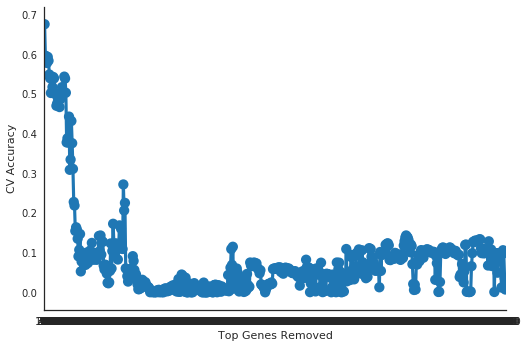

In [483]:
# Plot change in accuracy over iterations
sns.set_context('notebook')
plotr = pandas.DataFrame(index=range(len(cv_acc)), columns = ['Top Genes Removed','CV Accuracy'])
#plotr.loc[:,'Top Genes Removed'] = range(100,5100,100)
plotr.loc[:,'Top Genes Removed'] = range(100,58610,100)
plotr.loc[:,'CV Accuracy'] = cv_acc
plt.close()
sns.factorplot(x='Top Genes Removed', y = 'CV Accuracy', data=plotr, aspect=1.5, size=5)
plt.show()

Now repeat except remove 100 random probes instead of 100 top probes

In [10]:
null_cv_acc = []
fxp = pandas.DataFrame(xp, copy=True)
for i in range(585):
    print('round',i)
    jnk = PCA_LR_pipeline(fxp.values.T, 
                            (df.position_along_hipp_AP_axis), 
                            cv_strategy='score', illustrative=False,
                               sanity_check_style = 'model')
    null_cv_acc.append(jnk['CV_scores'])
    
    dropper = np.random.randint(0,len(fxp.index),100)
    fxp.drop(dropper, inplace=True)
    fxp.index = range(len(fxp.index))

In [11]:
# LOOKS LIKE I DIDN'T TAKE IT ALL THE WAY...
for i in range(585,589):
    print('round',i)
    jnk = PCA_LR_pipeline(fxp.values.T, 
                            (df.position_along_hipp_AP_axis), 
                            cv_strategy='score', illustrative=False,
                               sanity_check_style = 'model')
    null_cv_acc.append(jnk['CV_scores'])

    dropper = np.random.randint(0,len(fxp.index),100)
    fxp.drop(dropper, inplace=True)
    fxp.index = range(len(fxp.index))

In [ ]:
# PUT IT ALL TOGETHER
plotr = pandas.DataFrame(index=range(len(cv_acc)*2), 
                         columns = ['Genes Removed','CV Accuracy (r2)', 
                                    'Category'])
#plotr.loc[:,'Genes Removed'] = list(range(100,5100,100))*2
plotr.loc[:,'Genes Removed'] = list(range(100,59000,100))*2
plotr.loc[:,'CV Accuracy (r2)'] = cv_acc + null_cv_acc
#plotr.loc[:,'Category'] = ['Top Genes' if x <50 else 'Random Genes' for x in range(100)]
plotr.loc[:,'Category'] = ['Top Genes' if x <589 else 'Random Genes' for x in range(1178)]
sns.set_context('poster')


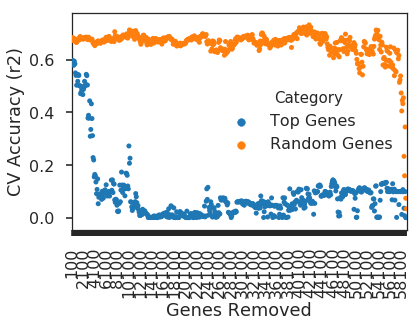

In [442]:
# PLOT IT
plt.close()
g = sns.stripplot(x='Genes Removed', y = 'CV Accuracy (r2)', hue = 'Category',
             data=plotr)
for ind, label in enumerate(g.get_xticklabels()):
    #if ind % 10 == 0:  # every 10th label is kept
    if ind % 20 == 0:  # every 20th label is kept
        label.set_visible(True)
        label.set_rotation(90)
    else:
        label.set_visible(False)
#plt.savefig(os.path.join(fig_dir,'CV_Acc_gene_removal_589.pdf'),
#           bbox_inches='tight')
plt.show()

In [25]:
### STOPPING POINTS OF EACH GENE SET
step1 = 100
step2 = 600
step3 = 2800

In [59]:
# SUMMARIZE INFORMATION OF TOP 5000 GENES...
mod_genes = pandas.DataFrame(index = range(5000),
                            columns = ['probe_ind','ant-post','step'])
mod_genes.loc[:,'probe_ind'] = imp_genes
mod_genes.loc[:,'gene_symbol'] = probes.loc[mod_genes['probe_ind'].values,'gene_symbol'].values
mod_genes.loc[:,'step'] = [1 if x <= step1 else 2 if x <= step2 else 3 if x <= step3 else 4 for x in range(5000)]
ant_ind,post_ind = [],[]
for i in range(50):
    post_ind += (np.arange(50) + (100*i)).tolist()
    ant_ind += (np.arange(50,100) + (100*i)).tolist()
mod_genes.loc[post_ind,'ant-post'] = 'posterior'
mod_genes.loc[ant_ind,'ant-post'] = 'anterior'
mod_genes.head()

,probe_ind,ant-post,step,gene_symbol
0,12941,posterior,1,GAL
1,47792,posterior,1,A_24_P102119
2,8962,posterior,1,ONECUT2
3,26238,posterior,1,PDLIM5
4,343,posterior,1,COL5A2


In [15]:
mod_genes.to_csv(os.path.join(wdir,'MAIN_model_genes_of_importance.csv'))

In [23]:
mod_genes = pandas.read_csv(os.path.join(wdir, 'MAIN_model_genes_of_importance.csv'),
                           index_col=0)
mod_genes.index = mod_genes.probe_ind
mod_genes.head()

,probe_ind,ant-post,step,gene_symbol
probe_ind,,,,
12941,12941,posterior,1,GAL
47792,47792,posterior,1,A_24_P102119
8962,8962,posterior,1,ONECUT2
26238,26238,posterior,1,PDLIM5
343,343,posterior,1,COL5A2


# Comparing individual gene sets in predicting A-P axis

In [24]:
# Get a Probe x Sample matrix for each "gene set"
top_100 = xp.loc[mod_genes[mod_genes.step==1].index]
top_100_600 = xp.loc[mod_genes[mod_genes.step==2].index]
top_600 = xp.loc[mod_genes[mod_genes.step<3].index]
top_600_2700 = xp.loc[mod_genes[mod_genes.step==3].index]
top_2700 = xp.loc[mod_genes[mod_genes.step<4].index]
top_2700_5k = xp.loc[mod_genes[mod_genes.step==4].index]
t5k_ind = [x for x in xp.index if x not in mod_genes.probe_ind.values]
top_5k_end = xp.loc[t5k_ind]
all_subs = xp.loc[mod_genes.loc[mod_genes.index].index]


In [25]:
# ID non-overlapping gene sets
gene_sets = [top_100, top_100_600, 
             top_600_2700, top_2700_5k,
            top_5k_end, all_subs]

# Make empty dataframe
hla_scores = pandas.DataFrame(index = range(180), columns = ['score','model_type','sample'])
hla_scores.loc[:,'model_type'] = (['model']*10 + ['null']*10 + ['inner set (100)']*10) * 6
hla_scores.loc[:,'sample'] = ['Set1 (n=100)']*30 + ['Set2 (n=500)']*30 + \
                             ['Set3 (n=1100)']*30 + ['Set4 (n=2300)']*30 + \
                             ['Not in Sets1-4 (n=53k)']*30 + ['all (n=58k)']*30


For each non-overlapping gene-set, performing the following models:
* Perform 10 (bootstrapped) models using only probes in the gene set
* Perform 10 "null" models involving n-length sets of randomly selected probes where n equals the size of the gene set
* Perform 10 "inner-set" models involving 100 probes randomly selected from *within* the gene set.

This latter comparison is to compare to other sets to Set 1, which contains only 100 probes.

In [83]:
#### THIS ALSO TAKES QUITE A LONG TIME TO RUN

i = 0
for g,gset in enumerate(gene_sets):
    if g==0:
        hla_scores.loc[i:i+9,'score'] = hap.bootstrap_model(gset, xp, 
                                                            df.position_along_hipp_AP_axis, 
                                                            smallset=True)
        i += 10
        hla_scores.loc[i:i+9,'score'] = hap.bootstrap_model(gset, xp, 
                                                            df.position_along_hipp_AP_axis, 
                                                            bs_type='null', smallset=True)
        i += 10
        hla_scores.loc[i:i+9,'score'] = hap.bootstrap_model(gset, xp, 
                                                            df.position_along_hipp_AP_axis,
                                                            bs_type='inner_set', inner_set=100, 
                                                            smallset=True)
        i += 10
    else:
        hla_scores.loc[i:i+9,'score'] = hap.bootstrap_model(gset, xp, 
                                                            df.position_along_hipp_AP_axis)
        i += 10
        hla_scores.loc[i:i+9,'score'] = hap.bootstrap_model(gset, xp, 
                                                            df.position_along_hipp_AP_axis, 
                                                            bs_type='null')
        i += 10
        hla_scores.loc[i:i+9,'score'] = hap.bootstrap_model(gset, xp, 
                                                            df.position_along_hipp_AP_axis,
                                                            bs_type='inner_set', inner_set=100)
        i += 10

Plot it

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


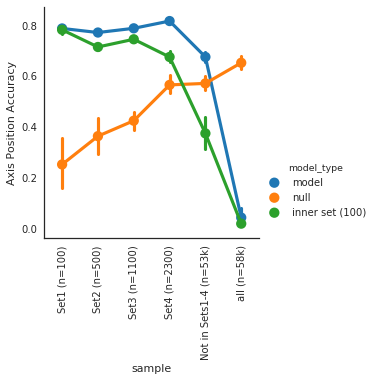

In [188]:
sns.set_context('notebook')
plt.close()
g = sns.factorplot(x='sample',y='score',hue='model_type',data=hla_scores)
g.set_xticklabels(g.ax.get_xticklabels(),rotation=90)
plt.ylabel('Axis Position Accuracy')
#plt.savefig(os.path.join(fig_dir,'model_comparison.pdf'), bbox_inches='tight')
plt.show()

In [27]:
# SAVE THE GENE SETS TO DISK AND SAVE THE PREDICTED VALUES TO SPREADSHEET FOR USE LATER
gsets = dict(zip(['top_100', 'top_100_600', 
             'top_600_2700', 'top_2700_5k',
            'top_5k_end']
                 ,gene_sets[:-1]))
gsets.update({'top_600': top_600})
gsets.update({'top_2700': top_2700})

for gset, xpdf in gsets.items():
    print('working on',gset)
    if gset != 'top_100':
        otpt = hap.PCA_LR_pipeline(xpdf.T, df.position_along_hipp_AP_axis, 
                               cv_strategy='score', illustrative=False, 
                                sanity_check_style ='model')
        pca_tfm = otpt['pca_object'].transform(xpdf.values.T) # transform with PCA
        predicted = otpt['final_model'].predict(pca_tfm) # get predicted values
    else:
        otpt = hap.PCA_LR_pipeline(xpdf.T, df.position_along_hipp_AP_axis, pca=None,
                            clf = linear_model.LassoCV(cv=10, max_iter=5000),
                            cv_strategy='score', illustrative=False,
                            sanity_check_style='model')
        predicted = otpt['final_model'].predict(xpdf.T) # get predicted values
    df.loc[:,gset] = predicted
    
    xpdf.to_csv(os.path.join(wdir,'GSET_%s_gxp.csv'%gset))

In [28]:
df.to_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info_W_SMALL_SETS.csv'))

## Use LIME do to some Feature Explaining!

running trial 0
Intercept 99.65319556495767
Prediction_local [96.83491432]
Right: 96.511
Intercept 96.33462292556528
Prediction_local [106.42473899]
Right: 107.906
Intercept 96.15132439510296
Prediction_local [107.35939123]
Right: 108.493
Intercept 99.16802477702234
Prediction_local [97.97357395]
Right: 97.632
Intercept 98.00411072649919
Prediction_local [101.86849432]
Right: 100.436
Intercept 96.70655317674907
Prediction_local [105.76834806]
Right: 107.353
Intercept 95.74679242777144
Prediction_local [108.54136918]
Right: 109.116
Intercept 96.71529949784416
Prediction_local [105.78803513]
Right: 107.148
Intercept 98.91901268139029
Prediction_local [98.9191163]
Right: 99.146
Intercept 98.4727578673826
Prediction_local [99.96225763]
Right: 98.302
Intercept 100.64213722848733
Prediction_local [93.73896078]
Right: 93.18
Intercept 100.0165163218628
Prediction_local [95.68566053]
Right: 95.215
Intercept 100.41210413969235
Prediction_local [94.68388784]
Right: 92.945
Intercept 97.38119593923

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


14244 4.6 5
22547 26.6 27
23274 27.6 28
29383 43.6 44
40112 62.6 63
8892 96.6 97


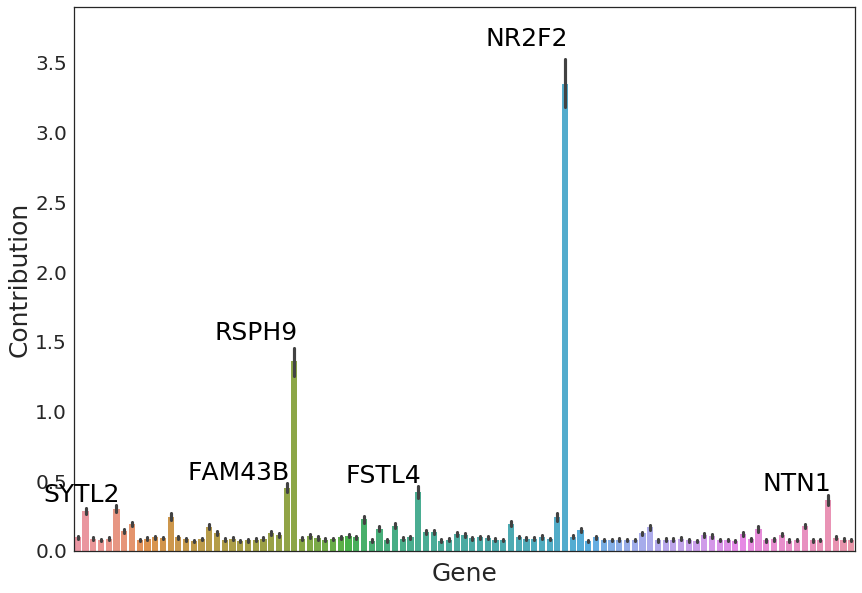

In [186]:
pltr = hap.feature_explainer_pipeline(top_100, 
                                      df.position_along_hipp_AP_axis, 
                                      probes)
# Scroll all the way down for plots

#### How does the model do without those top genes, compared to removing five random genes?

In [767]:
# ID selected probes
impgenes = ['RSPH9','FAM43B','FSTL4','NTN1','NR2F2']
imp_ind = [x for x in top_100.index if probes.loc[x, 'gene_symbol'] in impgenes]

# Make empty dataframe for results
n_genes = len(imp_ind)
imp_rem_res = pandas.DataFrame(index = range(n_iter+1),
                               columns = ['model','r2'])
# Drop the selected probes
c=0
jnk = pandas.DataFrame(top_100, copy=True)
jnk.drop(imp_ind, inplace=True)
# Run model without those probes
newmod = PCA_LR_pipeline(jnk.values.T,
                        (df.position_along_hipp_AP_axis), pca=None,
                        clf = linear_model.LassoCV(cv=10,max_iter=5000),
                        cv_strategy='score', illustrative=False,
                        sanity_check_style = 'model')
# Store results
imp_rem_res.loc[c,'model'] = 'True'
imp_rem_res.loc[c, 'r2'] = newmod['CV_scores']
c+=1

# Now repeat n times but selecting 5 random genes for removal
n_iter = 100
for i in range(n_iter):
    dsamp = np.random.choice(top_100.index, size = n_genes, replace=False)
    jnk = pandas.DataFrame(top_100, copy=True)
    jnk.drop(dsamp, inplace=True)
    newmod = PCA_LR_pipeline(jnk.values.T,
                            (df.position_along_hipp_AP_axis), pca=None,
                            clf = linear_model.LassoCV(cv=10,max_iter=5000),
                            cv_strategy='score', illustrative=False,
                            sanity_check_style = 'model')
    imp_rem_res.loc[c,'model'] = 'Null'
    imp_rem_res.loc[c, 'r2'] = newmod['CV_scores']
    c+=1

performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.76331520989
running final model
final model fit r2 =  0.885619268452
running sanity_check
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.780017955115
running final model
final model fit r2 =  0.899234112517
running sanity_check
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.805508947325
running final model
final model fit r2 =  0.91273549057
running sanity_check
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.81870606622
running final model
final model fit r2 =  0.909024093817
running sanity_check
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.793694345071
running final model
final model fit r2 =  0.905355526741
running sanity_check
performing model cross-validation
using basic 10-fold cross-validation
mo

Visualize results

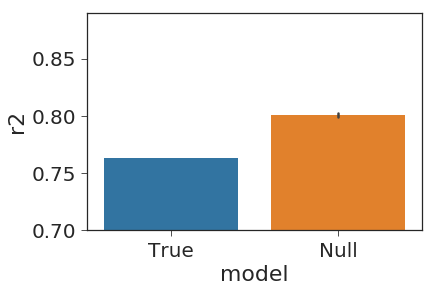

In [771]:
plt.close()
sns.barplot(x='model',y='r2',data=imp_rem_res,)
plt.ylim(0.7, 0.89)
plt.show()

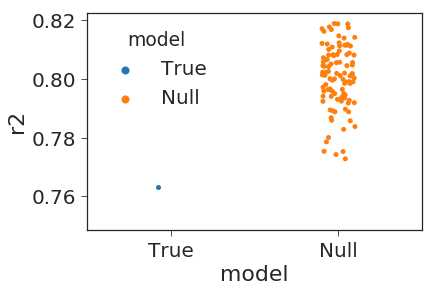

In [772]:
plt.close()
sns.stripplot(x='model',y='r2',hue='model',data=imp_rem_res, jitter=True)
#plt.ylim(0.7, 0.89)
plt.show()

## Find "bigrams" (similar features) to the "most important" features
This function will search all available probes that have collinear expression patterns to a target probe, and will return some information. 

           r2       r   name   rank
30409  0.3036  0.5510  SYTL2  58387
14246  0.5563  0.7459  SYTL2  58684
14245  0.5573  0.7465  SYTL2  58685
14244  0.5682  0.7538  SYTL2  58687
correlation greater than 0.999914809514% of other genes


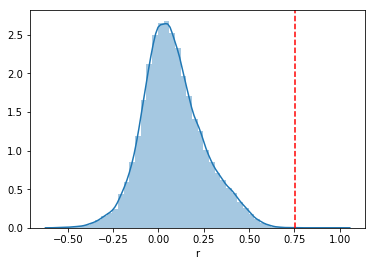

           r2       r     name   rank
17746  0.0155  0.1243  PLEKHO2  32627
17747  0.5237  0.7237  PLEKHO2  58681
correlation greater than 0.999812580931% of other genes


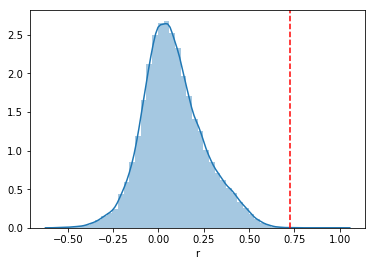

          r2       r  name   rank
3527  0.5016  0.7082  MT2A  58678
3525  0.5095  0.7138  MT2A  58679
3526  0.5196  0.7208  MT2A  58680
correlation greater than 0.999795542834% of other genes


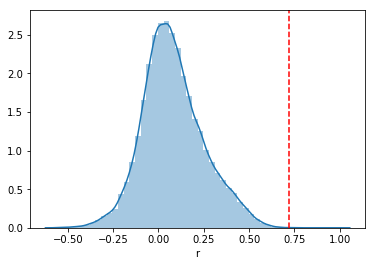

In [1010]:
# NR2F2
hap.find_bigram(xp, 40112, probes.gene_symbol, report = False, check_type = 'r2', check_val=0.5,
            check_genes = probes.loc[top_600_2700.index,'gene_symbol'].unique().tolist())

          r2       r   name   rank
23275  0.355  0.5958  RSPH9  58680
23274  1.000  1.0000  RSPH9  58691
correlation greater than 0.999982961903% of other genes


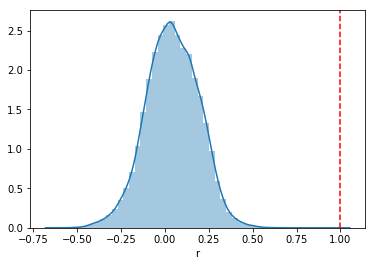

In [1049]:
# RSPH9
hap.find_bigram(xp, 23274, probes.gene_symbol, report = False, check_type = 'r2', check_val=0.5,
            check_genes = probes.loc[top_2700.index,'gene_symbol'].unique().tolist())

         r2       r    name   rank
343  0.1681  0.4100  COL5A2  51238
344  0.3834  0.6192  COL5A2  57732
345  0.5153  0.7179  COL5A2  58544
correlation greater than 0.997478361617% of other genes


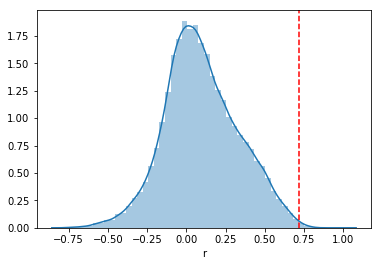

           r2       r    name   rank
22546  0.1694  0.4116  FAM43B  51303
22547  1.0000  1.0000  FAM43B  58691
correlation greater than 0.999982961903% of other genes


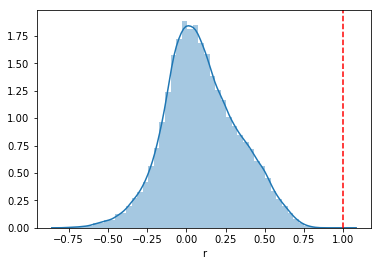

          r2       r   name   rank
5009  0.4314  0.6568  PVALB  58163
5008  0.5105  0.7145  PVALB  58531
correlation greater than 0.997256866353% of other genes


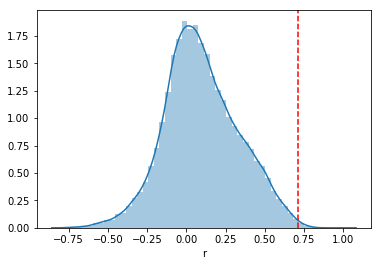

           r2       r          name   rank
27224  0.4696 -0.6853  RP11-45B20.3  58390
correlation greater than 0.99485449465% of other genes


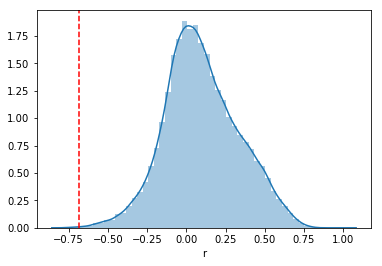

           r2       r  name   rank
27202  0.0167  0.1292  CD36  25753
37571  0.5303 -0.7282  CD36  58578
42596  0.5440 -0.7376  CD36  58607
correlation greater than 0.998551761739% of other genes


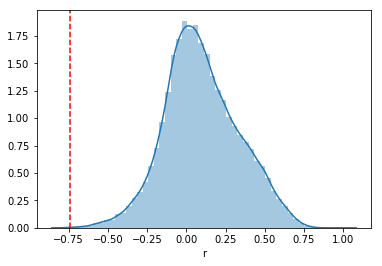

           r2       r name   rank
41256  0.1256 -0.3544  MYB  48143
3668   0.4235 -0.6508  MYB  58103
correlation greater than 0.989964560758% of other genes


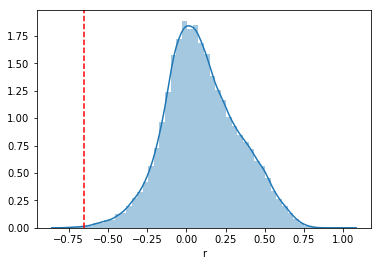

           r2       r   name   rank
10214  0.1819 -0.4264  GPR83  52050
10215  0.2238 -0.4731  GPR83  53987
10216  0.4431 -0.6656  GPR83  58252
correlation greater than 0.992503237238% of other genes


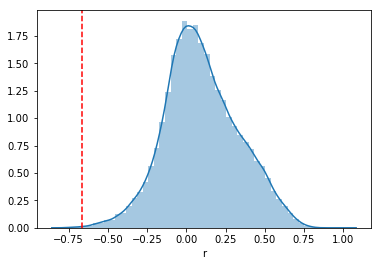

           r2       r   name   rank
24482  0.1829 -0.4277  RSPO2  52106
24484  0.3511 -0.5925  RSPO2  57326
24483  0.4377 -0.6616  RSPO2  58216
correlation greater than 0.99188986574% of other genes


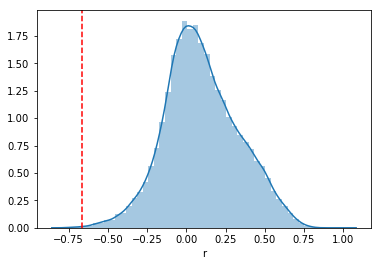

In [998]:
# FAM43B
hap.find_bigram(xp, 22547, probes.gene_symbol, report = False, check_type = 'r2', check_val=0.4,
            check_genes = probes.loc[top_100.index,'gene_symbol'].unique().tolist())

           r2       r   name   rank
29384  0.7905  0.8891  FSTL4  58690
29383  1.0000  1.0000  FSTL4  58691
correlation greater than 0.999982961903% of other genes


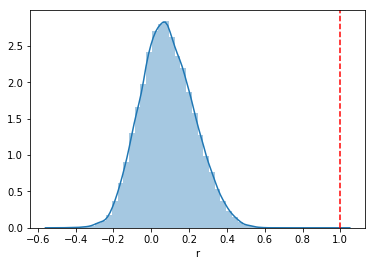

In [1002]:
# FSTL4
hap.find_bigram(xp, 29383, probes.gene_symbol, report = False, check_type = 'r2', check_val=0.4,
            check_genes = probes.loc[top_100.index,'gene_symbol'].unique().tolist())

#### Let's do some "Feature Explainers for other gene sets. Starting with Gene Set 2:

In [ ]:
pltr = hap.feature_explainer_pipeline(top_100_600, df.position_along_hipp_AP_axis, 
                                      probes, nm_thresh=0.2)

#### Gene set 1 + 2 Combined

In [ ]:
pltr = hap.feature_explainer_pipeline(top_600, df.position_along_hipp_AP_axis, 
                                      probes, nm_thresh=0.2)

#### Gene Set 3

In [ ]:
pltr = hap.feature_explainer_pipeline(top_600_2700, df.position_along_hipp_AP_axis, 
                                      probes, nm_thresh=0.2)

#### Gene set 1 + 2 + 3 Combined

In [ ]:
pltr = hap.feature_explainer_pipeline(top_2700, df.position_along_hipp_AP_axis, 
                                      probes, nm_thresh=0.2)

## Viewing expression patterns of top genes

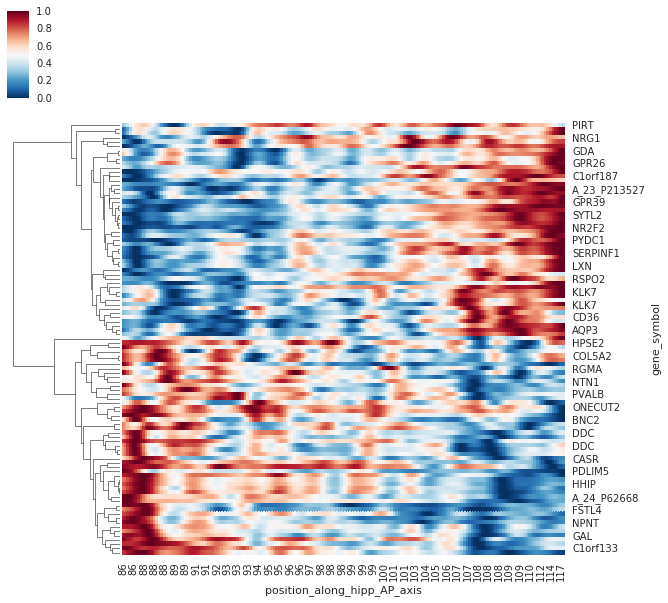

In [192]:
# Gene Set 1

# Identify gene set
jnk = xp.loc[mod_genes[mod_genes.step==1]['probe_ind'],
            xp.columns[df.sort_values('position_along_hipp_AP_axis').index]]

# Smooth the data along X (axis position) with a 3mm kernel for easier viewing/clustering
sjnk = pandas.DataFrame(ndimage.gaussian_filter1d(jnk,3,1), 
                        index = probes.loc[jnk.index,'gene_symbol'], 
                        columns = df.sort_values('position_along_hipp_AP_axis').position_along_hipp_AP_axis)
# Cluster and plot
plt.close()
g = sns.clustermap(sjnk,
               col_cluster=False, metric='correlation', standard_scale=0,
               cmap='RdBu_r')
#g.fig.set_figheight(18)
#g.fig.savefig(os.path.join(fig_dir,'top100_cluster.pdf'), bbox_inches='tight')
plt.show()

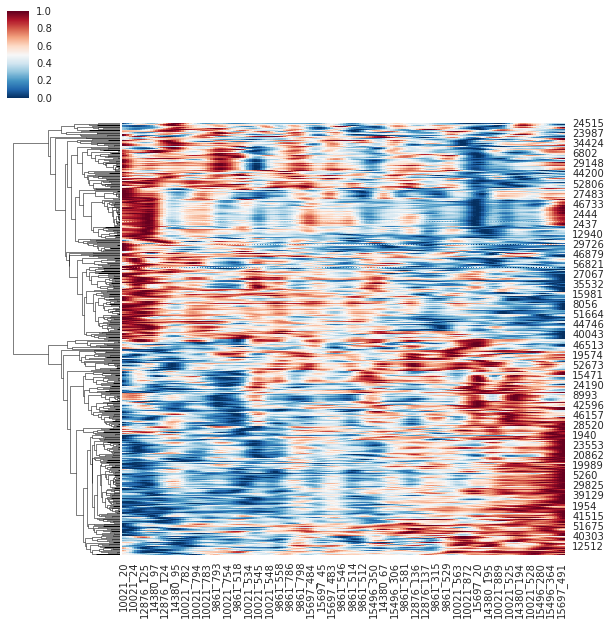

In [193]:
# Repeat for Gene Set 1 + 2

jnk = xp.loc[mod_genes[mod_genes.step<3]['probe_ind'],
            xp.columns[df.sort_values('position_along_hipp_AP_axis').index]]
sjnk = pandas.DataFrame(ndimage.gaussian_filter1d(jnk,3,1), index = jnk.index, columns = jnk.columns) 
plt.close()
g2 = sns.clustermap(sjnk,
               col_cluster=False, metric='correlation', standard_scale=0,
               cmap='RdBu_r')
plt.show()

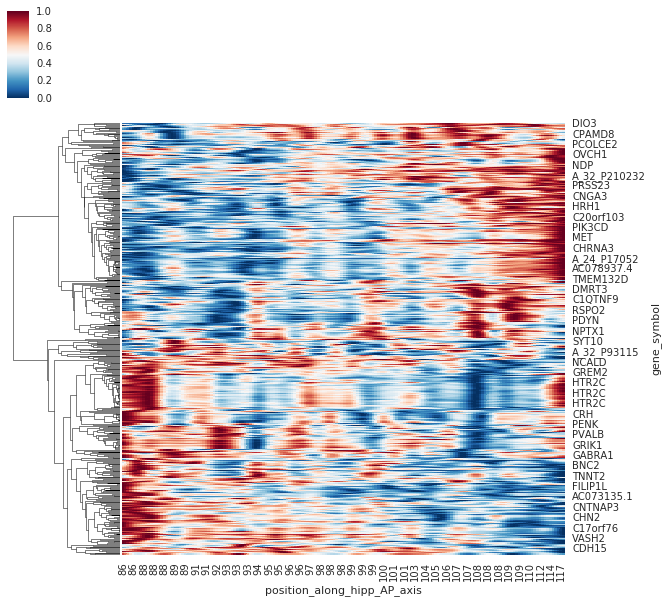

In [195]:
# Repeat for Gene Set 2 alone

jnk = xp.loc[mod_genes[mod_genes.step==2]['probe_ind'],
            xp.columns[df.sort_values('position_along_hipp_AP_axis').index]]
sjnk = pandas.DataFrame(ndimage.gaussian_filter1d(jnk,3,1), 
                       index = probes.loc[jnk.index,'gene_symbol'], 
                       columns = df.sort_values('position_along_hipp_AP_axis').position_along_hipp_AP_axis) 
plt.close()
g2a = sns.clustermap(sjnk,
               col_cluster=False, metric='correlation', standard_scale=0,
               cmap='RdBu_r')
#g2a.fig.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/top1_600_cluster.pdf')
plt.show()

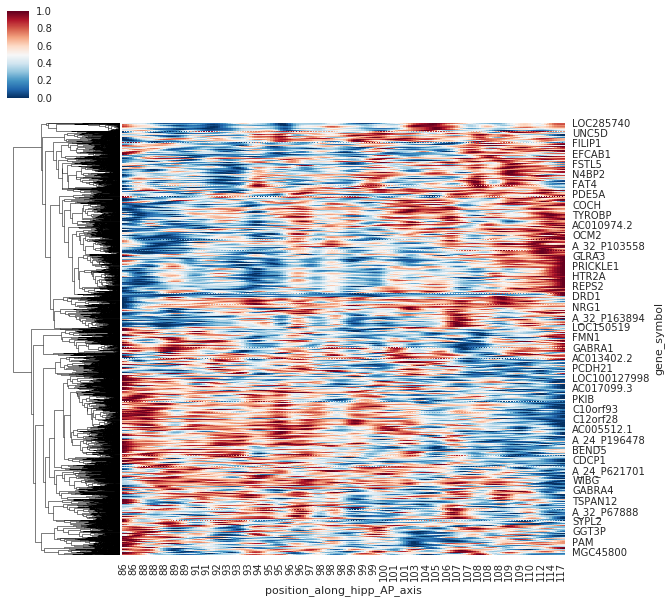

In [196]:
# Repeat for Gene Set 3 alone

jnk = xp.loc[mod_genes[mod_genes.step==3]['probe_ind'],
            xp.columns[df.sort_values('position_along_hipp_AP_axis').index]]
sjnk = pandas.DataFrame(ndimage.gaussian_filter1d(jnk,3,1),
                       index = probes.loc[jnk.index,'gene_symbol'], 
                       columns = df.sort_values('position_along_hipp_AP_axis').position_along_hipp_AP_axis) 
plt.close()
g3a = sns.clustermap(sjnk,
               col_cluster=False, metric='correlation', standard_scale=0,
               cmap='RdBu_r')
#g3a.fig.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/top6_2700_cluster.pdf')
plt.show()

## Making meaningful clusters out of gene/annotation relationships
For Gene Sets 2 and 3, there were many, many "hits" indicating enriched functions, processes and components. These analyses attempt to cluster the individual genes into clusters of shared enriched terms.

#### Gene Set 2

In [11]:
# Locate spreadsheets, which were generated using GOrilla

# Specifically, the specific genes produced in Set 1 and 2 above we're passed to GOrilla, and all genes
# available in the dataset were entered as background.

go_proc = os.path.join(wdir,'GOPROCESS.xls')
go_comp = os.path.join(wdir,'GOCOMPONENT.xls')
go_func = os.path.join(wdir,'GOFUNCTION.xls')
gos = [go_proc,go_comp,go_func]

In [213]:
# Consolidate into a dataframe
go_gsea = hap.prepare_GO_terms(top_100_600, gos, probes)
go_gsea.head()

,anterograde trans-synaptic signaling,chemical synaptic transmission,synaptic signaling,trans-synaptic signaling,nervous system process,system process,behavior,signal transduction,cell communication,multicellular organismal process,...,chemorepellent activity,ammonium ion binding,chloride channel activity,ligand-gated cation channel activity,GABA-gated chloride ion channel activity,ion transmembrane transporter activity,hormone activity,excitatory extracellular ligand-gated ion channel activity,G-protein coupled peptide receptor activity,GTPase inhibitor activity
PTX3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GABRA1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
PDCD6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HTR2C,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TAC1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


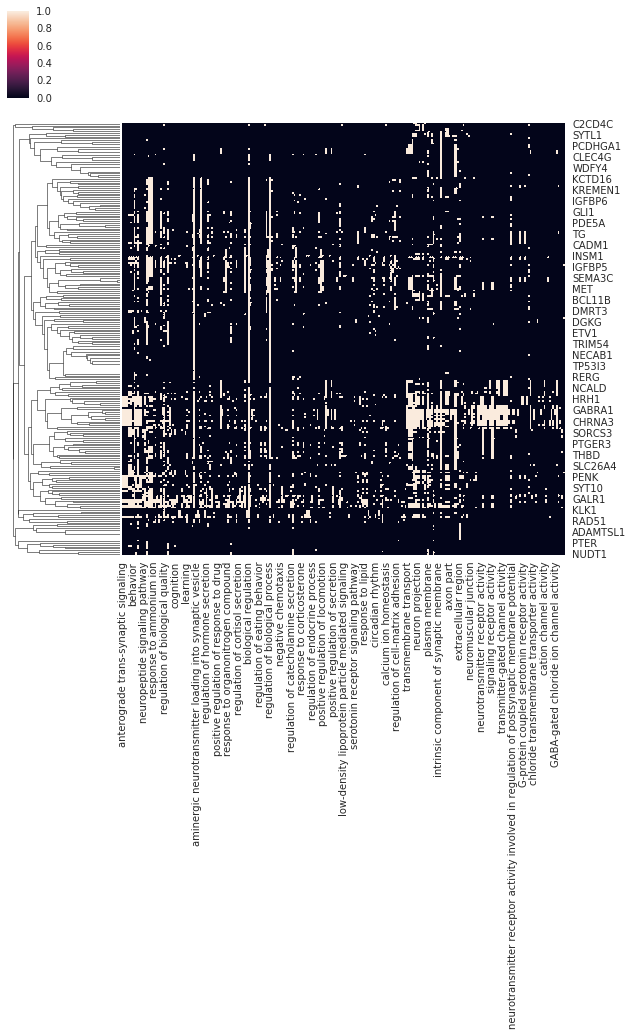

In [214]:
# Quick preview of what the clusters might look like

plt.close()
sns.clustermap(go_gsea, metric='jaccard', col_cluster=False)
plt.show()

In [793]:
# Cluster using 2-30-cluster solutions and compare based on silhouette scores and CH index 

# Create results dataframe
ks = range(2,31)
go_solutions2 = pandas.DataFrame(index = ks, columns = ['silhouette', 'CH_index',
                                                             'mean_size','min_size','max_size'])
X = go_gsea.values.T
for k in ks:
    # Perform cluster analysis
    connectivity = kneighbors_graph(X, n_neighbors=10, mode='distance', 
                                    metric = 'jaccard', include_self=False)
    clusterer = AgglomerativeClustering(n_clusters=k, connectivity=connectivity)
    cluster_labels = clusterer.fit_predict(X)
    # silhouette
    go_solutions2.loc[k,'silhouette'] = silhouette_score(X, cluster_labels)
    # CH Index
    go_solutions2.loc[k,'CH_index'] = calinski_harabaz_score(X, cluster_labels)
    # Get information on cluster size
    mtx2 = pandas.DataFrame(go_gsea.T.values, copy=True)
    mtx2.loc[:,'label'] = cluster_labels
    sizes = []
    for i in np.unique(mtx2.label):
        clus_data = mtx2[mtx2.label==i][mtx2.columns[:-1]]
        sizes.append(len(clus_data))
    # SIZES
    go_solutions2.loc[k,'mean_size'] = np.mean(sizes)
    go_solutions2.loc[k,'min_size'] = np.min(sizes)
    go_solutions2.loc[k,'max_size'] = np.max(sizes)
    print('finished',k)
go_solutions2.loc[:,'k'] = go_solutions2.index

finished 2
finished 3
finished 4
finished 5
finished 6
finished 7
finished 8
finished 9
finished 10
finished 11
finished 12
finished 13
finished 14
finished 15
finished 16
finished 17
finished 18
finished 19
finished 20
finished 21
finished 22
finished 23
finished 24
finished 25
finished 26
finished 27
finished 28
finished 29
finished 30


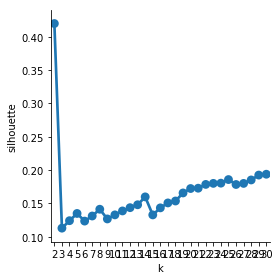

In [794]:
plt.close()
sns.factorplot(x='k',y='silhouette',data=go_solutions2)
plt.show()

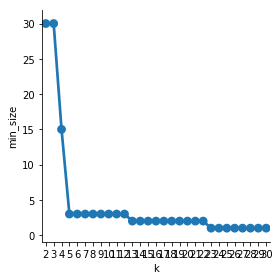

In [796]:
plt.close()
sns.factorplot(x='k',y='min_size',data=go_solutions2)
plt.show()

cluster 0
n =  58


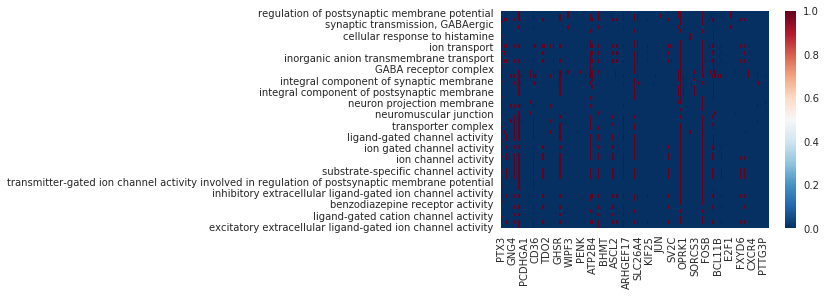

GRIA3      0.707317
FXYD6      0.692308
TRPM3      0.619048
NCALD      0.619048
KCNN3      0.590909
KCNK12     0.590909
GABRA2     0.573171
GABRA4     0.569767
GABRA1     0.560440
GABRD      0.539683
CHRNA1     0.520548
GABRQ      0.515625
KCNH5      0.500000
GABRB2     0.481481
GRIK1      0.462963
SLC2A12    0.461538
SLC39A2    0.461538
SLC26A4    0.444444
CNGA3      0.439024
HTR3A      0.386667
dtype: float64
['regulation of postsynaptic membrane potential', 'regulation of membrane potential', 'ion transmembrane transport', 'synaptic transmission, GABAergic', 'excitatory postsynaptic potential', 'chloride transmembrane transport', 'cellular response to histamine', 'response to histamine', 'chloride transport', 'ion transport', 'gamma-aminobutyric acid signaling pathway', 'inorganic ion transmembrane transport', 'inorganic anion transmembrane transport', 'transmembrane transport', 'GABA-A receptor complex', 'GABA receptor complex', 'synapse', 'plasma membrane region', 'integral compon

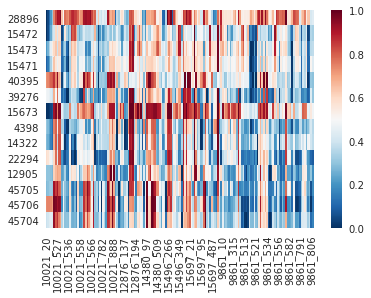

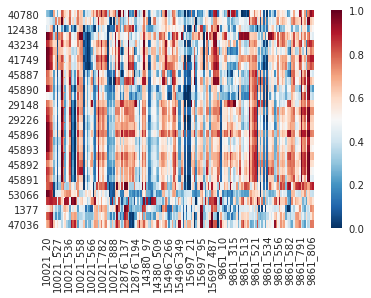




cluster 1
n =  15


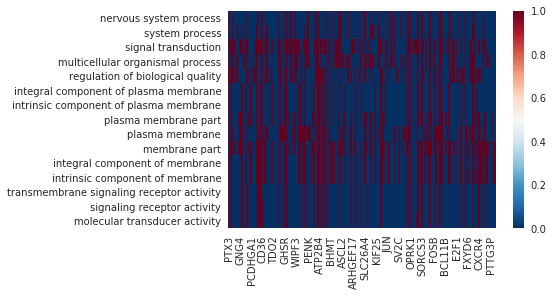

TMEM74B    1.000000
DCBLD1     1.000000
WDFY4      1.000000
CLDN20     1.000000
PCDHGA1    0.857143
PCDHB8     0.857143
MALL       0.833333
MARCH1     0.800000
DCHS2      0.800000
CNTNAP3    0.800000
TRHR       0.733333
SGCG       0.700000
MEGF11     0.666667
FRMPD2     0.666667
NTSR2      0.600000
IFNLR1     0.600000
GPR88      0.600000
SCARA5     0.538462
SLC2A12    0.538462
SLC39A2    0.538462
dtype: float64
['nervous system process', 'system process', 'signal transduction', 'multicellular organismal process', 'regulation of biological quality', 'integral component of plasma membrane', 'intrinsic component of plasma membrane', 'plasma membrane part', 'plasma membrane', 'membrane part', 'integral component of membrane', 'intrinsic component of membrane', 'transmembrane signaling receptor activity', 'signaling receptor activity', 'molecular transducer activity']


KeyboardInterrupt: 

In [226]:
# Run clustering based on using a solution of K=8

subfields = df.structure_acronym.unique()
k = 8 

# Perform clustering and extract labels
X = go_gsea.values.T
connectivity = kneighbors_graph(X, n_neighbors=10, mode='distance', 
                                    metric = 'jaccard', include_self=False)
clusterer = AgglomerativeClustering(n_clusters=k, connectivity=connectivity)
cluster_labels = clusterer.fit_predict(X)
mtx2 = pandas.DataFrame(go_gsea.T, copy=True)
mtx2.loc[:,'label'] = cluster_labels

# For each cluster
for i in np.unique(mtx2.label):
    print('cluster',i)
    # Extract data from the cluster
    clus_data = mtx2[mtx2.label==i][mtx2.columns[:-1]]
    print('n = ',len(clus_data))
    # Plot it
    plt.close()
    sns.heatmap(pandas.DataFrame(clus_data),
               cmap = 'RdBu_r')
    plt.show()
    
    # Identify the most frequently enriched terms in the cluster
    # and the percentage of genes in the cluster that show enrichment
    # for each term
    top_hits = (clus_data.sum()/go_gsea.T.sum()).sort_values(ascending=False).head(20)
    print(top_hits)
    # Print the most enriched genes
    print(clus_data.index.tolist())
    
    # A bunch of extra exploratory stuff
    plt.close()
    # Identify which genes are posteriorly expressed vs. anteriorly expressed
    # Good god this next line is hideous. I'm so sorry.
    xp_mtx = g2.data2d.loc[[x for x in g2.data2d.index if x in probes[probes.gene_symbol.isin(top_hits.index)
                                                                     ].index]].reindex(columns=xp.columns)
    rs = [stats.pearsonr(xp_mtx.loc[i],df.position_along_hipp_AP_axis.values)[0] for i in xp_mtx.index]
    ap = np.array(['a' if x > 0 else 'p' for x in rs])
    amtx = xp_mtx.loc[xp_mtx.index[ap=='a']]
    pmtx = xp_mtx.loc[xp_mtx.index[ap=='p']]
    # Print the number of anterior vs posterior genes
    print('%s anterior, %s posterior'%(len(amtx),len(pmtx)))
    # And which they are
    print('anterior:', probes.loc[amtx.index,'gene_symbol'].unique())
    print('posterior:', probes.loc[pmtx.index,'gene_symbol'].unique())
    phdf = pandas.DataFrame(df,copy=True)
    phdf.loc[:,'a_gxp'] = amtx.mean().values
    phdf.loc[:,'p_gxp'] = pmtx.mean().values
    # Store the cluster's association with axis position
    ar = stats.pearsonr(phdf.a_gxp,phdf.position_along_hipp_AP_axis)[0]**2
    pr = stats.pearsonr(phdf.p_gxp,phdf.position_along_hipp_AP_axis)[0]**2
    print('anterior r2 = %s, posterior r2 = %s'%(ar,pr))
    # And separately for each subfield
    for subfield in subfields:
        ars = stats.pearsonr(phdf[phdf.structure_acronym==subfield]['a_gxp'],
                             df[df.structure_acronym==subfield].position_along_hipp_AP_axis)[0]**2
        prs = stats.pearsonr(phdf[phdf.structure_acronym==subfield]['p_gxp'],
                             df[df.structure_acronym==subfield].position_along_hipp_AP_axis)[0]**2
        print('%s anterior = %s, posterior = %s'%(subfield,ars,prs))

    # Plot the raw expression patterns of the anterior and posterior genes in the cluster
    sns.heatmap(amtx,cmap='RdBu_r')
    plt.show()
    plt.close()
    sns.heatmap(pmtx,cmap='RdBu_r')
    plt.show()
    #for x in clus_data.index:
    #    print(x)
    print('\n\n')

### Looks great! Repeat with Set 3!

In [12]:
go_proc = os.path.join(wdir,'GOPROCESS_6_2700.xlsx')
go_comp = os.path.join(wdir,'GOCOMPONENT_6_2700.xlsx')
go_func = os.path.join(wdir,'GOFUNCTION_6_2700.xlsx')
gos = [go_proc,go_comp,go_func]


In [13]:
go_gsea = hap.prepare_GO_terms(top_600_2700, gos, probes)
go_gsea.head()

,anterograde trans-synaptic signaling,chemical synaptic transmission,synaptic signaling,trans-synaptic signaling,system process,cell-cell signaling,ion transport,signaling,cell communication,ion transmembrane transport,...,carboxylic acid transmembrane transporter activity,monovalent inorganic cation transmembrane transporter activity,cGMP binding,chloride transmembrane transporter activity,transmembrane receptor protein tyrosine kinase activity,organic anion transmembrane transporter activity,benzodiazepine receptor activity,GABA receptor activity,vitamin D binding,vascular endothelial growth factor-activated receptor activity
GABRA1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
COL25A1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CPNE8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CARTPT,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HTR2C,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [632]:
ks = range(2,50)
go_solutions = pandas.DataFrame(index = ks, columns = ['silhouette', 'CH_index',
                                                             'mean_size','min_size','max_size'])
X = go_gsea.values
for k in ks:
    connectivity = kneighbors_graph(X, n_neighbors=100, mode='distance', 
                                    metric = 'jaccard', include_self=False)
    clusterer = AgglomerativeClustering(n_clusters=k, connectivity=connectivity)
    cluster_labels = clusterer.fit_predict(X)
    # silhouette
    go_solutions.loc[k,'silhouette'] = silhouette_score(X, cluster_labels)
    # CH Index
    go_solutions.loc[k,'CH_index'] = calinski_harabaz_score(X, cluster_labels)
    mtx = pandas.DataFrame(go_gsea.values, copy=True)
    mtx.loc[:,'label'] = cluster_labels
    sizes = []
    for i in np.unique(mtx.label):
        clus_data = mtx[mtx.label==i][mtx.columns[:-1]]
        sizes.append(len(clus_data))
    # SIZES
    go_solutions.loc[k,'mean_size'] = np.mean(sizes)
    go_solutions.loc[k,'min_size'] = np.min(sizes)
    go_solutions.loc[k,'max_size'] = np.max(sizes)
    print('finished',k)
go_solutions.loc[:,'k'] = go_solutions.index

finished 2
finished 3
finished 4
finished 5
finished 6
finished 7
finished 8
finished 9
finished 10
finished 11
finished 12
finished 13
finished 14
finished 15
finished 16
finished 17
finished 18
finished 19
finished 20
finished 21
finished 22
finished 23
finished 24
finished 25
finished 26
finished 27
finished 28
finished 29
finished 30
finished 31
finished 32
finished 33
finished 34
finished 35
finished 36
finished 37
finished 38
finished 39
finished 40
finished 41
finished 42
finished 43
finished 44
finished 45
finished 46
finished 47
finished 48
finished 49


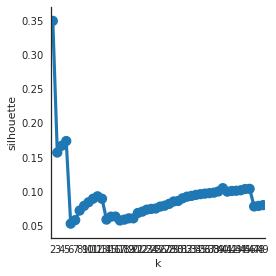

In [501]:
plt.close()
sns.factorplot(x='k',y='silhouette',data=go_solutions)
plt.show()

cluster 0
n =  281


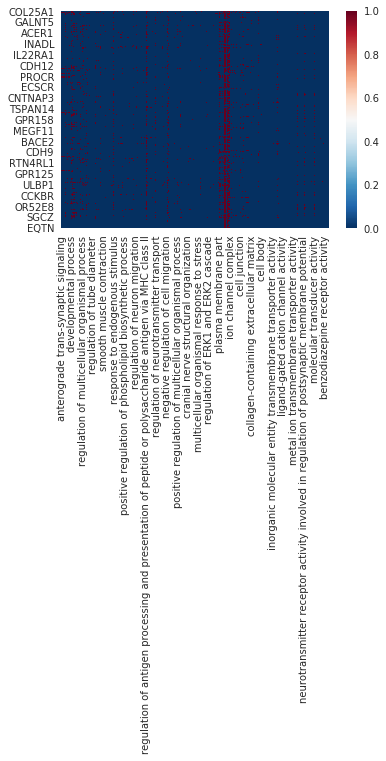

peptide antigen assembly with MHC class II protein complex                 1.000000
intrinsic component of membrane                                            0.553444
integral component of membrane                                             0.550868
cell adhesion                                                              0.516484
biological adhesion                                                        0.510870
membrane part                                                              0.472119
calcium ion binding                                                        0.400000
molecular transducer activity                                              0.394366
signaling receptor activity                                                0.392857
transmembrane signaling receptor activity                                  0.390244
cell surface                                                               0.376812
phospholipase C-activating G-protein coupled receptor signaling pathway    0

NameError: name 'g3' is not defined

In [230]:
k = 12 # based on silhouette and perc_hits
X = go_gsea.values
connectivity = kneighbors_graph(X, n_neighbors=100, mode='distance', 
                                    metric = 'jaccard', include_self=False)
clusterer = AgglomerativeClustering(n_clusters=k, connectivity=connectivity)
cluster_labels = clusterer.fit_predict(X)
mtx = pandas.DataFrame(go_gsea, copy=True)
mtx.loc[:,'label'] = cluster_labels
for i in np.unique(mtx.label):
    plt.close()
    print('cluster',i)
    clus_data = mtx[mtx.label==i][mtx.columns[:-1]]
    print('n = ',len(clus_data))
    sns.heatmap(pandas.DataFrame(clus_data),
               cmap = 'RdBu_r')
    plt.show()
    top_hits = (clus_data.sum()/go_gsea.sum()).sort_values(ascending=False).head(20)
    print(top_hits)
    print(clus_data.index.tolist())
    #for x in clus_data.index:
    #    print(x)
    print('\n\n')
    
    xp_mtx = g3.data2d.loc[[x for x in g3.data2d.index if x in probes[probes.gene_symbol.isin(clus_data.index.tolist())
                                                                     ].index]].reindex(columns=xp.columns)
    rs = [stats.pearsonr(xp_mtx.loc[i],df.position_along_hipp_AP_axis.values)[0] for i in xp_mtx.index]
    ap = np.array(['a' if x > 0 else 'p' for x in rs])
    amtx = xp_mtx.loc[xp_mtx.index[ap=='a']]
    pmtx = xp_mtx.loc[xp_mtx.index[ap=='p']]
    print('%s anterior, %s posterior'%(len(amtx),len(pmtx)))
    print('anterior:', probes.loc[amtx.index,'gene_symbol'].unique())
    print('posterior:', probes.loc[pmtx.index,'gene_symbol'].unique())
    phdf = pandas.DataFrame(df,copy=True)
    phdf.loc[:,'a_gxp'] = amtx.mean().values
    phdf.loc[:,'p_gxp'] = pmtx.mean().values
    ar = stats.pearsonr(phdf.a_gxp,phdf.position_along_hipp_AP_axis)[0]**2
    pr = stats.pearsonr(phdf.p_gxp,phdf.position_along_hipp_AP_axis)[0]**2
    print('anterior r2 = %s, posterior r2 = %s'%(ar,pr))
    for subfield in subfields:
        ars = stats.pearsonr(phdf[phdf.structure_acronym==subfield]['a_gxp'],
                             df[df.structure_acronym==subfield].position_along_hipp_AP_axis)[0]**2
        prs = stats.pearsonr(phdf[phdf.structure_acronym==subfield]['p_gxp'],
                             df[df.structure_acronym==subfield].position_along_hipp_AP_axis)[0]**2
        print('%s anterior = %s, posterior = %s'%(subfield,ars,prs))

    sns.heatmap(amtx,cmap='RdBu_r')
    plt.show()
    plt.close()
    sns.heatmap(pmtx,cmap='RdBu_r')
    plt.show()